In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np

def read_metric(path):
    with open(path, 'rb') as f:
        dict_split = pickle.load(f)
        true=[]; ctrl=[]; pred=[]
        for k, v in dict_split.items():
            del v['DE_idx']
            expr = pd.DataFrame.from_dict(v, orient='index')
            true.append(expr.loc[['Truth']].rename(index={'Truth': k}))
            ctrl.append(expr.loc[['Ctrl']].rename(index={'Ctrl': k}))
            pred.append(expr.loc[['Pred']].rename(index={'Pred': k}))
        true = pd.concat(true)
        ctrl = pd.concat(ctrl)
        pred = pd.concat(pred)
    return true, ctrl, pred

biolord_df_true = []; biolord_df_ctrl = []; biolord_df_pred = []; 
gears_df_true = []; gears_df_ctrl = []; gears_df_pred = []; 
for i in range(1,6):
    biolord_true, biolord_ctrl, biolord_pred,= read_metric(f'../../results/biolord/biolord_norman_combo_seen1_{i}.pkl')
    biolord_df_true.append(biolord_true)
    biolord_df_ctrl.append(biolord_ctrl)
    biolord_df_pred.append(biolord_pred)
    
    gears_true, gears_ctrl, gears_pred = read_metric(f'../../results/GEARS/GEARS_norman_combo_seen1_{i}.pkl')
    gears_df_true.append(gears_true)
    gears_df_ctrl.append(gears_ctrl)
    gears_df_pred.append(gears_pred)

biolord_df_true = pd.concat(biolord_df_true)
biolord_df_ctrl = pd.concat(biolord_df_ctrl)
biolord_df_pred = pd.concat(biolord_df_pred)
new_rname = [i.split('_')[1] for i in list(biolord_df_ctrl.index)]
biolord_df_true.index = new_rname
biolord_df_ctrl.index = new_rname
biolord_df_pred.index = new_rname

gears_df_true = pd.concat(gears_df_true)
gears_df_ctrl = pd.concat(gears_df_ctrl)
gears_df_pred = pd.concat(gears_df_pred)

with open('../../results/Scouter/Scouter_norman_5.pkl', 'rb') as f:
    scouter_df = pickle.load(f)
    scouter_genes = list(scouter_df.keys())
    common = np.intersect1d(np.intersect1d(biolord_df_true.index, gears_df_true.index), scouter_genes)

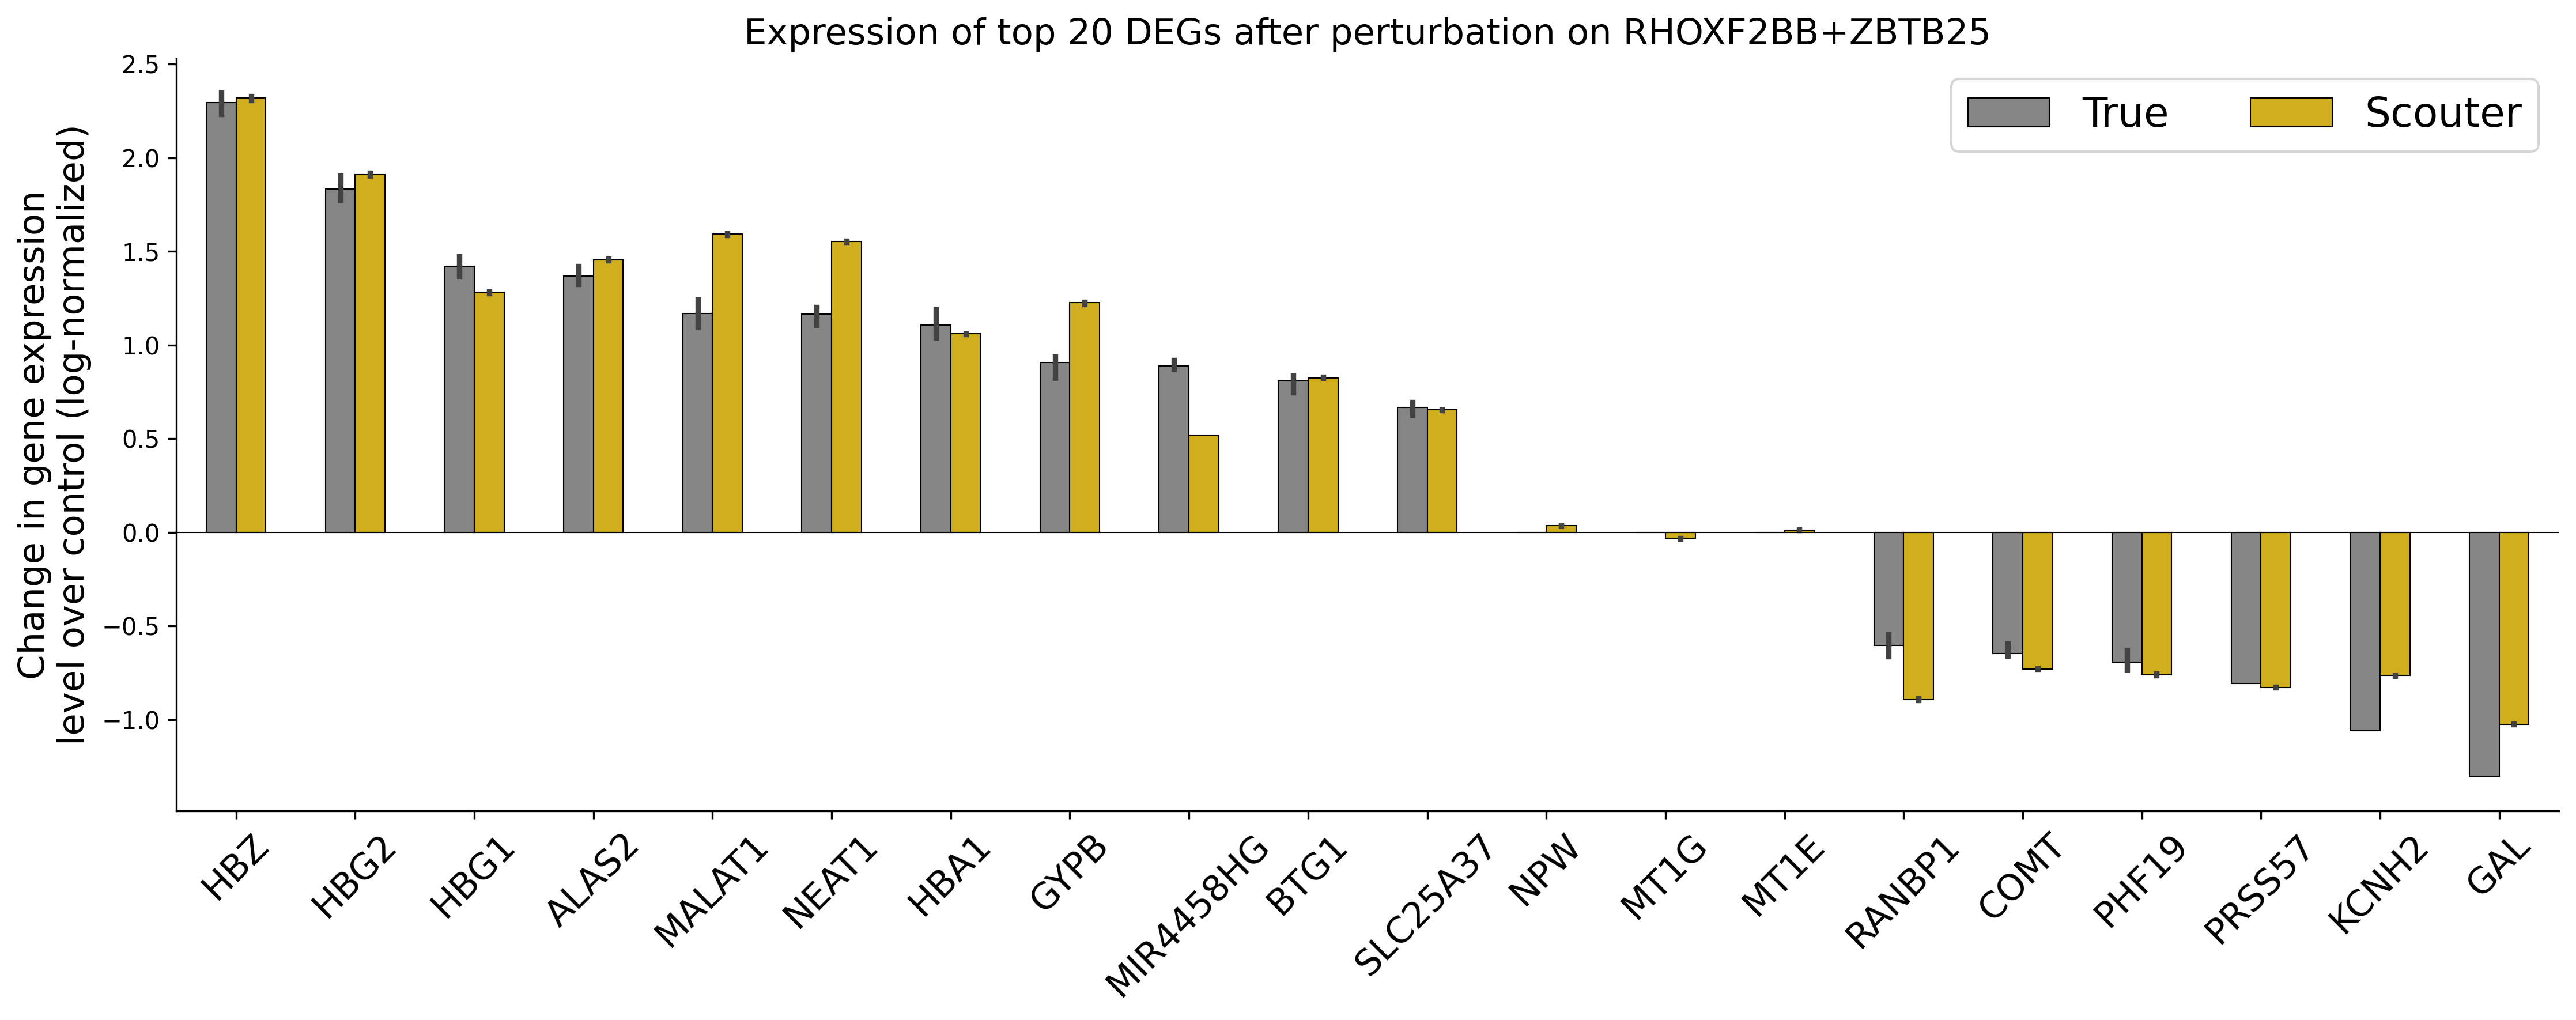

In [2]:
gene1 = 'RHOXF2BB+ZBTB25'
DE_idx = scouter_df[gene1]['DE_idx']
DE_name = scouter_df[gene1]['DE_name']
scouter_ctrl = pd.DataFrame(scouter_df[gene1]['Ctrl'], columns=DE_name)
scouter_true = pd.DataFrame(scouter_df[gene1]['Truth'], columns=DE_name)
scouter_pred = pd.DataFrame(scouter_df[gene1]['Pred'], columns=DE_name)

scouter_true_delta = (scouter_true - scouter_ctrl.median()).assign(Group='True')
scouter_pred_delta = (scouter_pred - scouter_ctrl.median()).assign(Group='Scouter')
merge = pd.concat([scouter_true_delta,scouter_pred_delta])
df_melted = merge.melt(id_vars='Group', var_name='Gene', value_name='Expression')
df_melted['Group'] = pd.Categorical(df_melted['Group'], categories=['True', 'Scouter'], ordered=True)
gene_orders = list(scouter_true_delta.drop('Group', axis=1).median().sort_values(ascending=False).index)
df_melted['Gene'] = pd.Categorical(df_melted['Gene'], categories=gene_orders, ordered=True)

custom_palette = {
    'True': '#868686FF',
    'Scouter': '#EFC000FF'
}
plt.figure(figsize=(15 ,6), dpi=300)
ax = sns.barplot(data=df_melted, x="Gene", y="Expression", hue="Group", width=0.5, 
                      palette=custom_palette, estimator='median', errorbar=("ci", 50))
for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(0.5)
plt.legend(loc='upper right', ncol=3, fontsize=17)
plt.xticks(rotation=45, fontsize=15)
plt.title(f'Expression of top 20 DEGs after perturbation on {gene1}', fontsize=15)
plt.xlabel('')
plt.ylabel('Change in gene expression\nlevel over control (log-normalized)', fontsize=15)
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=0, color='black', linewidth=0.5, linestyle='-')
plt.show()

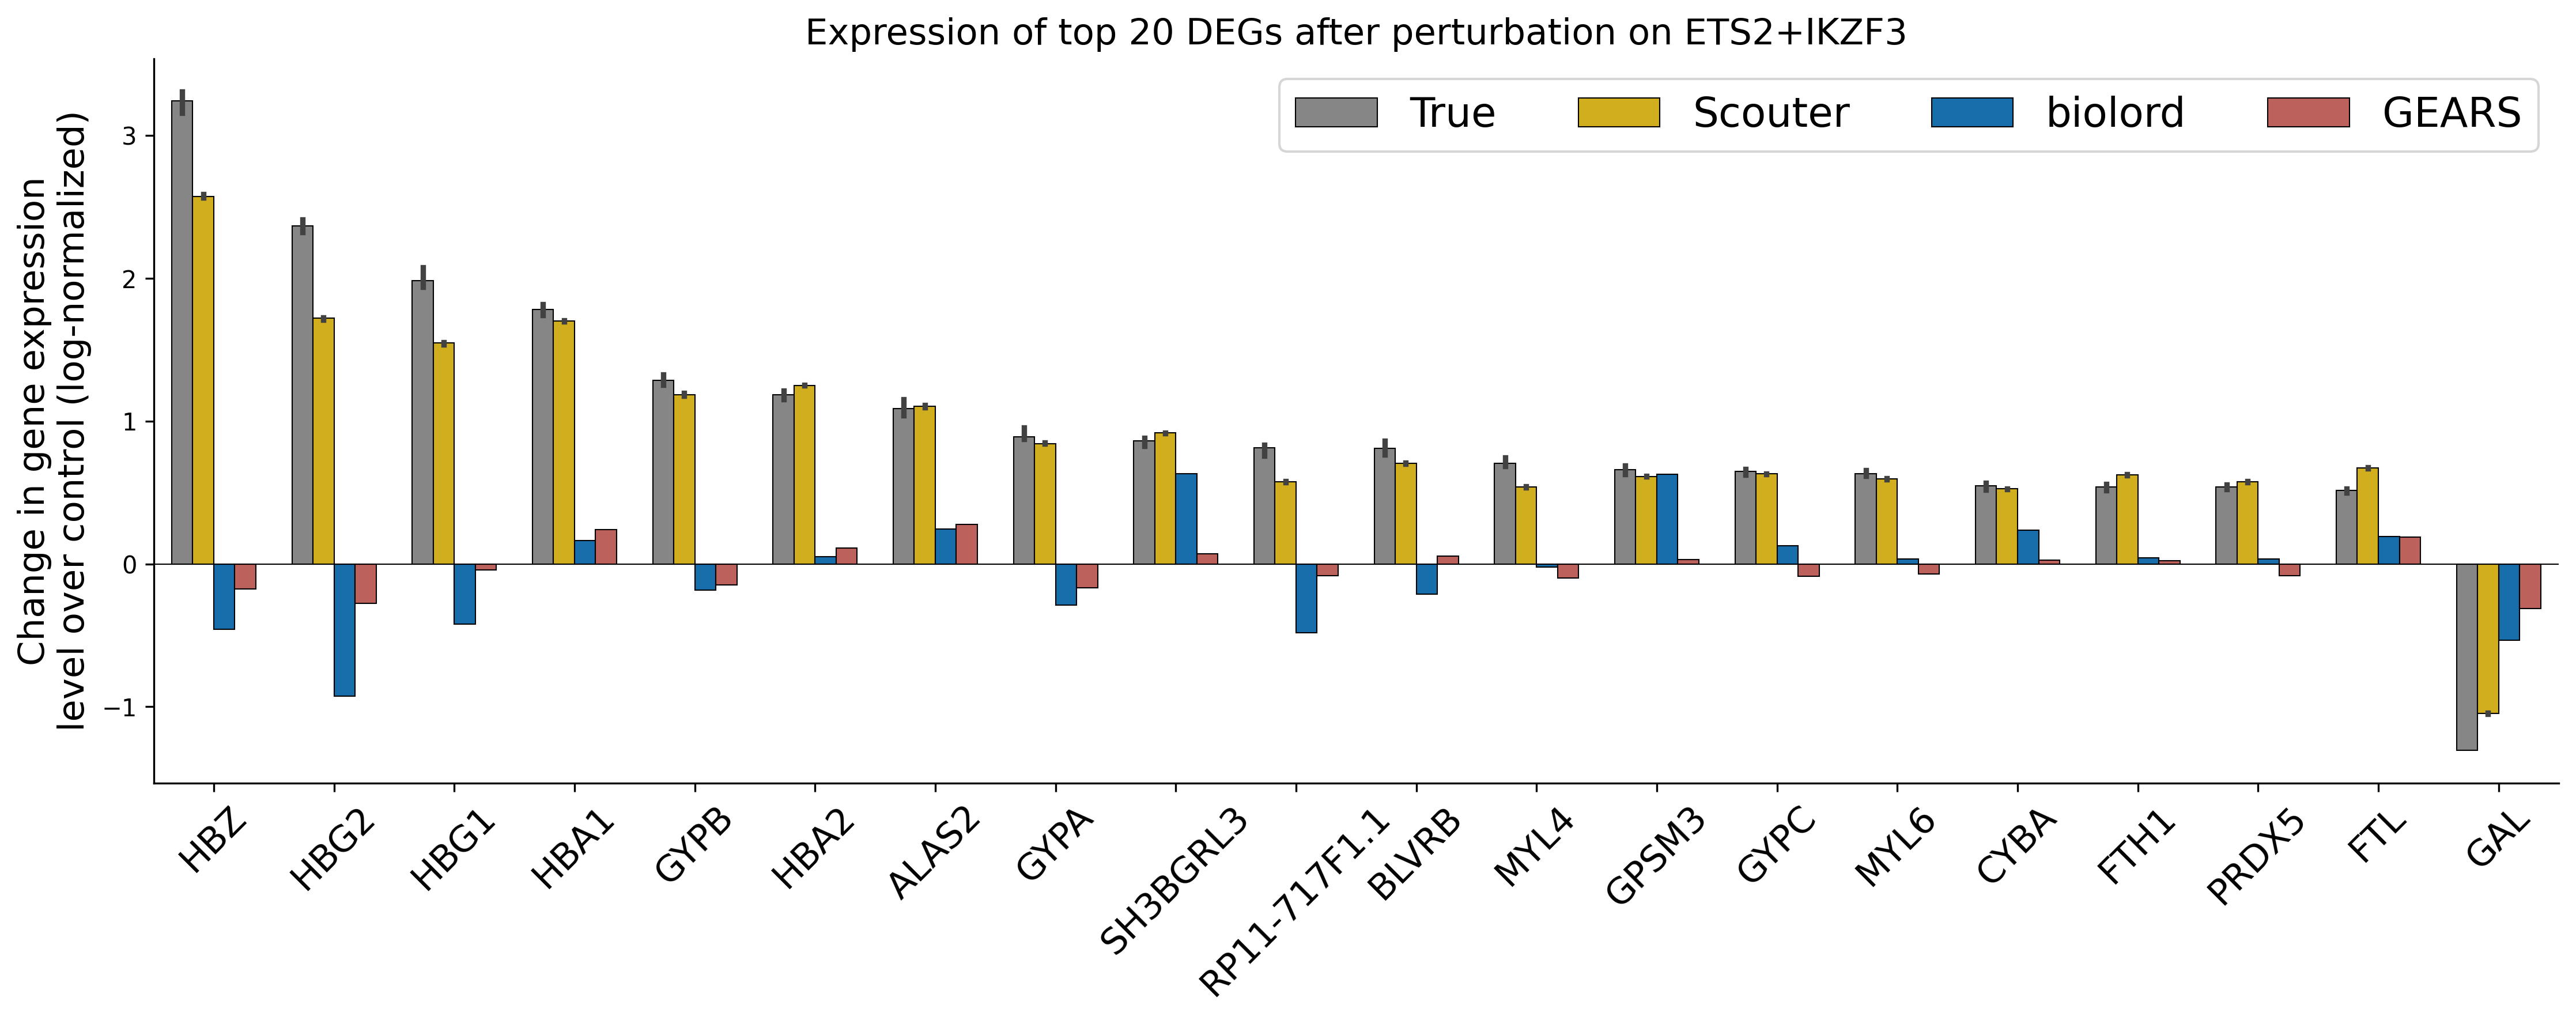

In [3]:
gene2 = 'ETS2+IKZF3'
DE_idx = scouter_df[gene2]['DE_idx']
DE_name = scouter_df[gene2]['DE_name']
scouter_ctrl = pd.DataFrame(scouter_df[gene2]['Ctrl'], columns=DE_name)
scouter_true = pd.DataFrame(scouter_df[gene2]['Truth'], columns=DE_name)
scouter_pred = pd.DataFrame(scouter_df[gene2]['Pred'], columns=DE_name)

scouter_true_delta = (scouter_true - scouter_ctrl.median()).assign(Group='True')
scouter_pred_delta = (scouter_pred - scouter_ctrl.median()).assign(Group='Scouter')

biolord_pred = biolord_df_pred.loc[[gene2]][DE_idx]
biolord_pred.columns=DE_name
biolord_pred = (biolord_pred-scouter_ctrl.median()).assign(Group='biolord').iloc[[0]]

gears_pred = gears_df_pred.loc[[gene2]][DE_idx]
gears_pred.columns=DE_name
gears_pred = (gears_pred-scouter_ctrl.median()).assign(Group='GEARS').iloc[[0]]

merge = pd.concat([scouter_true_delta,scouter_pred_delta,biolord_pred, gears_pred])
df_melted = merge.melt(id_vars='Group', var_name='Gene', value_name='Expression')
gene_orders = list(scouter_true_delta.drop('Group', axis=1).median().sort_values(ascending=False).index)
df_melted['Gene'] = pd.Categorical(df_melted['Gene'], categories=gene_orders, ordered=True)

custom_palette = {
    'True': '#868686FF',
    'Scouter': '#EFC000FF',
    'biolord': '#0073C2FF',
    'GEARS': '#CD534CFF'
}
plt.figure(figsize=(15 ,6), dpi=300)
ax = sns.barplot(data=df_melted, x="Gene", y="Expression", hue="Group", width=0.7, 
                      palette=custom_palette, estimator='median', errorbar=("ci", 50))
for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(0.5)
plt.legend(loc='upper right', ncol=4, fontsize=17)
plt.xticks(rotation=45, fontsize=15)
plt.title(f'Expression of top 20 DEGs after perturbation on {gene2}', fontsize=15)
plt.xlabel('')
plt.ylabel('Change in gene expression\nlevel over control (log-normalized)', fontsize=15)
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=0, color='black', linewidth=0.5, linestyle='-')
plt.show()